In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal, ttest_ind
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import spearmanr
import seaborn as sns
import networkx as nx
import warnings

In [4]:
# Load dataset
data_path = "/home/sarita/Downloads/aiims/Dataset.csv"
data = pd.read_csv(data_path)


In [5]:
# Step 1: Summary of Dataset
print("Number of samples per cancer type:")
print(data['Cancertype'].value_counts())

Number of samples per cancer type:
Cancertype
BRCA    1119
UCEC     554
KIRC     542
LUAD     541
LGG      532
THCA     513
HNSC     504
LUSC     502
PRAD     501
COAD     483
SKCM     472
OV       430
STAD     420
BLCA     414
LIHC     374
CESC     306
KIRP     291
LAML     178
GBM      170
READ     167
ACC       79
KICH      66
UCS       57
DLBC      48
Name: count, dtype: int64


In [7]:
# Compute mean and standard deviation for each gene
gene_stats = data.drop(columns=['Sample', 'Cancertype']).agg(['mean', 'std']).T
gene_stats = gene_stats.sort_values(by='std', ascending=False)
top5_variable_genes = gene_stats.head(5)
print("Top 5 most variable genes:")
print(top5_variable_genes)

Top 5 most variable genes:
                 mean          std
UBB       7330.653614  4205.813034
HIST1H1C  1955.368684  3579.582470
UBC       5190.153905  2556.609357
PFN1      3298.034454  2039.389104
DAXX      4895.071901  1628.726865


In [13]:
from scipy.stats import kruskal

# Step 2: Identify Differentially Expressed Genes (Kruskal-Wallis Test)
selected_cancers = data['Cancertype'].unique()[:5]
filtered_data = data[data['Cancertype'].isin(selected_cancers)]

expr_matrix = filtered_data.drop(columns=['Sample', 'Cancertype'])

p_values = {}
for gene in expr_matrix.columns:
    groups = [expr_matrix.loc[filtered_data['Cancertype'] == cancer, gene] for cancer in selected_cancers]
    
    # Ensure there is variation in gene expression
    if all(group.nunique() > 1 for group in groups):
        p_values[gene] = kruskal(*groups).pvalue
    else:
        p_values[gene] = 1  # Assign a high p-value if there is no variation

adj_p_values = pd.Series(p_values).sort_values()
top10_genes = adj_p_values.head(10).index.tolist()

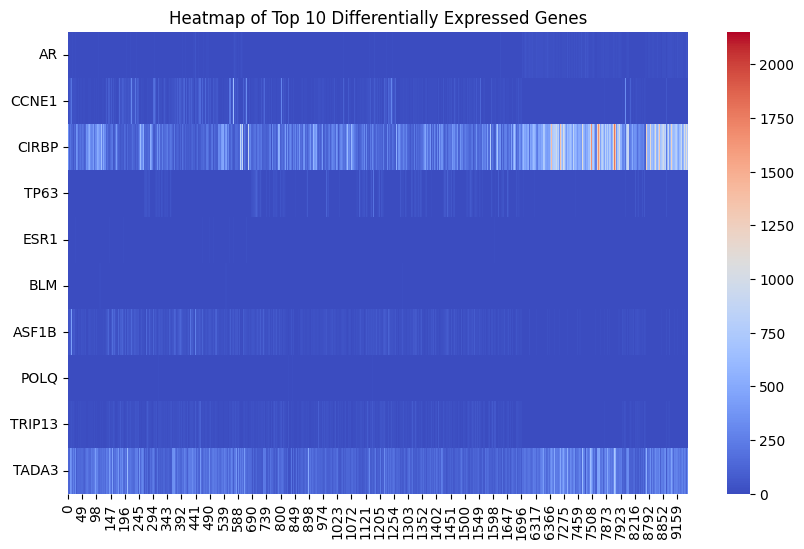

In [14]:
# Heatmap of Top 10 Genes
plt.figure(figsize=(10, 6))
sns.heatmap(filtered_data[top10_genes].T, cmap='coolwarm', yticklabels=top10_genes)
plt.title("Heatmap of Top 10 Differentially Expressed Genes")
plt.show()

/tmp/ipykernel_16584/2305294813.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Cluster'] = kmeans_clusters


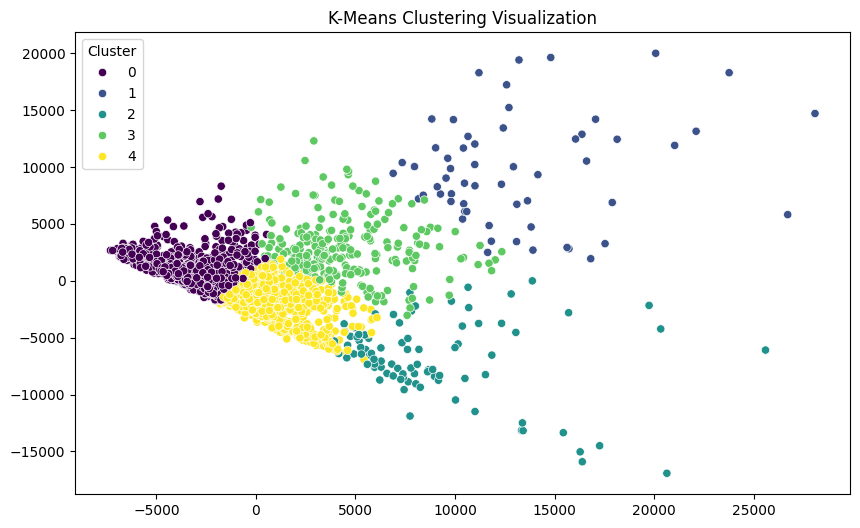

In [15]:
# Step 3: Clustering (Hierarchical & KMeans)
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_clusters = kmeans.fit_predict(expr_matrix)
filtered_data['Cluster'] = kmeans_clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(x=PCA(n_components=2).fit_transform(expr_matrix)[:, 0],
                y=PCA(n_components=2).fit_transform(expr_matrix)[:, 1],
                hue=filtered_data['Cluster'], palette='viridis')
plt.title("K-Means Clustering Visualization")
plt.show()

Variance explained by first two PCs: [0.34904871 0.19022237]


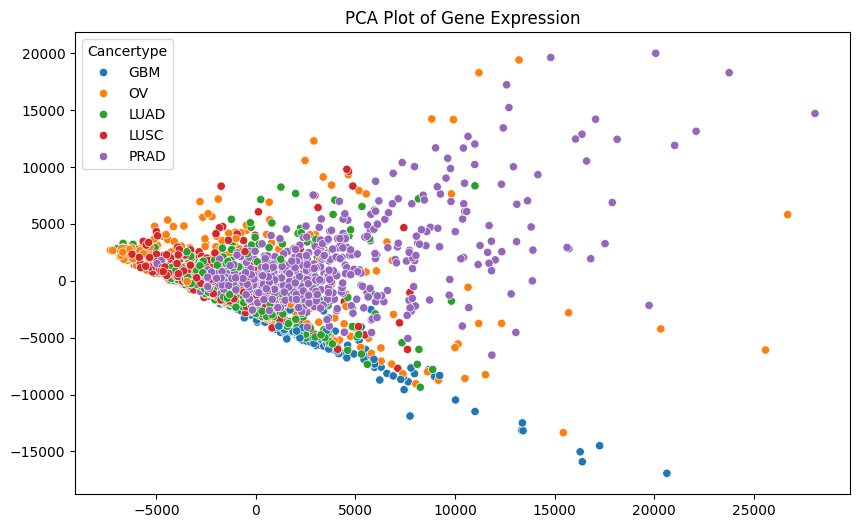

In [16]:
# Step 4: PCA Analysis
pca = PCA(n_components=2)
pca_result = pca.fit_transform(expr_matrix)
explained_variance = pca.explained_variance_ratio_[:2]

print(f"Variance explained by first two PCs: {explained_variance}")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=filtered_data['Cancertype'])
plt.title("PCA Plot of Gene Expression")
plt.show()

In [18]:
# Step 5: Machine Learning Model
X_train, X_test, y_train, y_test = train_test_split(expr_matrix, filtered_data['Cancertype'], test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         GBM       1.00      0.97      0.99        40
        LUAD       0.97      0.93      0.95       120
        LUSC       0.90      0.96      0.93        81
          OV       1.00      1.00      1.00        88
        PRAD       1.00      0.99      0.99       100

    accuracy                           0.97       429
   macro avg       0.97      0.97      0.97       429
weighted avg       0.97      0.97      0.97       429

Confusion Matrix:
[[ 39   0   1   0   0]
 [  0 112   8   0   0]
 [  0   3  78   0   0]
 [  0   0   0  88   0]
 [  0   1   0   0  99]]


In [19]:
# Step 6: Feature Importance
gene_importance = pd.Series(rf_model.feature_importances_, index=expr_matrix.columns)
top_features = gene_importance.nlargest(10)
print("Top Predictive Genes:")
print(top_features)

Top Predictive Genes:
TP63       0.030070
RBM38      0.017062
RASSF7     0.016649
ESR1       0.016091
CDC25B     0.013162
SETMAR     0.013042
FANCE      0.013026
AR         0.012858
RPS6KA6    0.012529
KPNA2      0.012270
dtype: float64


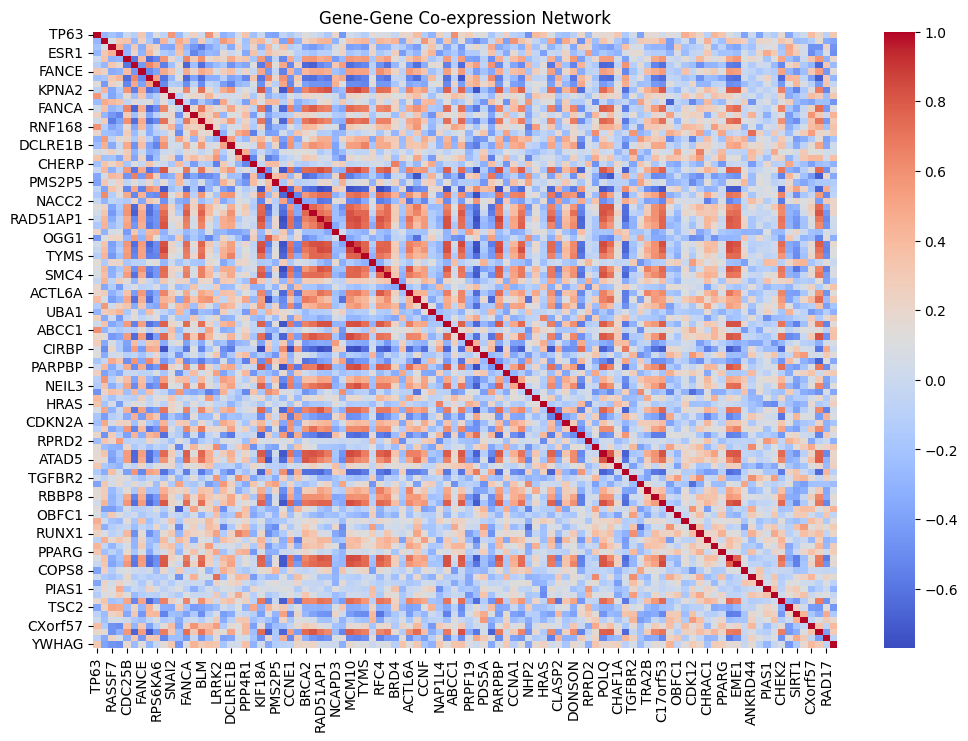

✅ Analysis completed successfully!


In [20]:
# Step 7: Gene-Gene Co-expression Network
top100_genes = gene_importance.nlargest(100).index
cor_matrix = expr_matrix[top100_genes].corr(method='spearman')
plt.figure(figsize=(12, 8))
sns.heatmap(cor_matrix, cmap='coolwarm')
plt.title("Gene-Gene Co-expression Network")
plt.show()

print("✅ Analysis completed successfully!")